In [217]:
# Mateusz Biegański
# mb385162

# SAD 2020-2021 MIMUW

In [218]:
# pretty print string formatting.
library("glue");

# 'reduce' operator.
# devtools::install_github("tidyverse/purrr")
library("purrr")

# useful stuff for plotting multiple histograms. 
library("tidyr")

# easy and beaufiful plots.
library("ggplot2")

# %>% operator.
library("dplyr")

In [219]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x, .envir=environment()))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))
id = function(x) x


In [220]:
# Read the data.
DATA_FNAME = "people.tsv"

df <- read.table(DATA_FNAME, header = TRUE,  sep = '\t',  stringsAsFactors = FALSE)
# df[which(df$pet == "none"),]$pet = NA

In [221]:
p("Number of observations: {nrow(df)}")

Number of observations: 500


In [222]:
head(df)

quantitive = c("age", "weight", "height", "number_of_kids", "expenses")
categorical = c("gender", "married", "pet")

p("Quantitive variables: {reduce(quantitive, paste, sep=', ')}")
p("Categorical variables: {reduce(categorical, paste, sep=', ')}")

,age,weight,height,gender,married,number_of_kids,pet,expenses
,<int>,<dbl>,<dbl>,<chr>,<lgl>,<int>,<chr>,<dbl>
1,25,61.7,121.12,other,FALSE,2,ferret,23.44299
2,37,63.9,145.00,man,TRUE,6,dog,96.83683
3,41,50.2,145.03,woman,TRUE,2,hedgehog,312.67693
4,43,72.4,179.90,man,FALSE,1,dog,447.42838
5,26,78.4,163.91,man,FALSE,1,hedgehog,-78.22799
6,49,59.4,151.86,woman,TRUE,2,ferret,1241.98263


Quantitive variables: age, weight, height, number_of_kids, expenses
Categorical variables: gender, married, pet


In [223]:
unique(df$pet)
unique(df$number_of_kids)

[1] "ferret"   "dog"      "hedgehog" "none"     "cat"

[1] 2 6 1 0 5 3 4

As we see, both _pet_ and _number of kids_ variables yield types are limited.

In [224]:
cor(df[quantitive])

,age,weight,height,number_of_kids,expenses
age,1.000000000,-0.03959492,-0.04130021,0.006910684,0.89278562
weight,-0.039594917,1.00000000,0.66969277,-0.032776730,0.03139451
height,-0.041300207,0.66969277,1.00000000,-0.039969222,0.03803458
number_of_kids,0.006910684,-0.03277673,-0.03996922,1.000000000,-0.04674781
expenses,0.892785621,0.03139451,0.03803458,-0.046747812,1.00000000


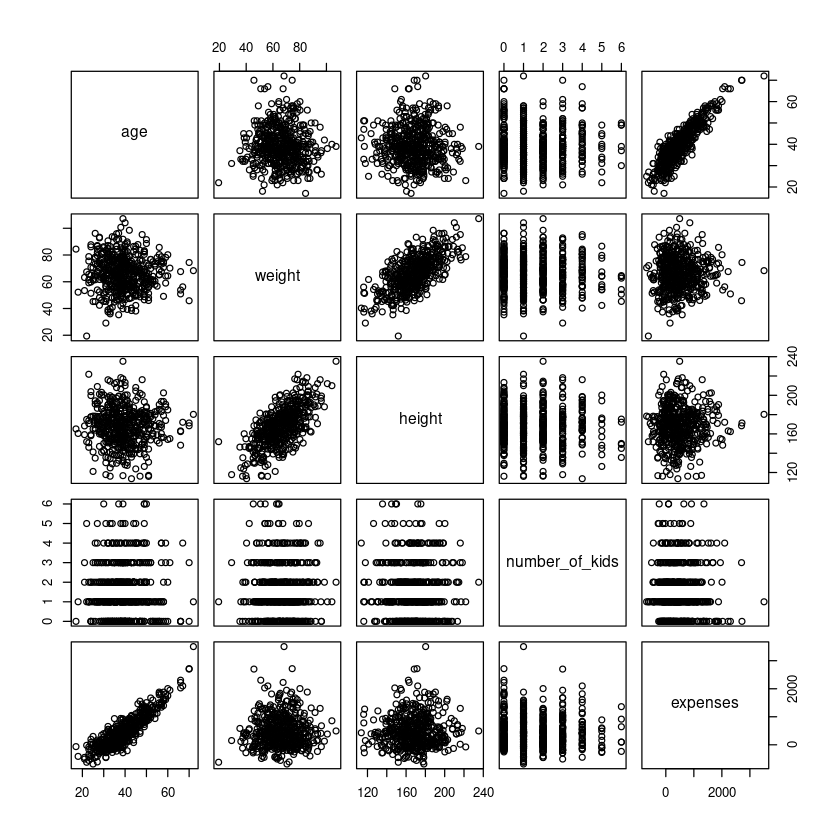

In [8]:
# Let's investigate variables correlaction.
pairs(df[quantitive])

As we can see, _height_ is positively correlated with _weight_, as well as _age_ is positively correlated with _expenses_. The second case is not harmful for our estimation, because _expenses_ is response variable - we can expect our regression model to have significant _age_ coefficient. 

For categorical variables dependencies check, 

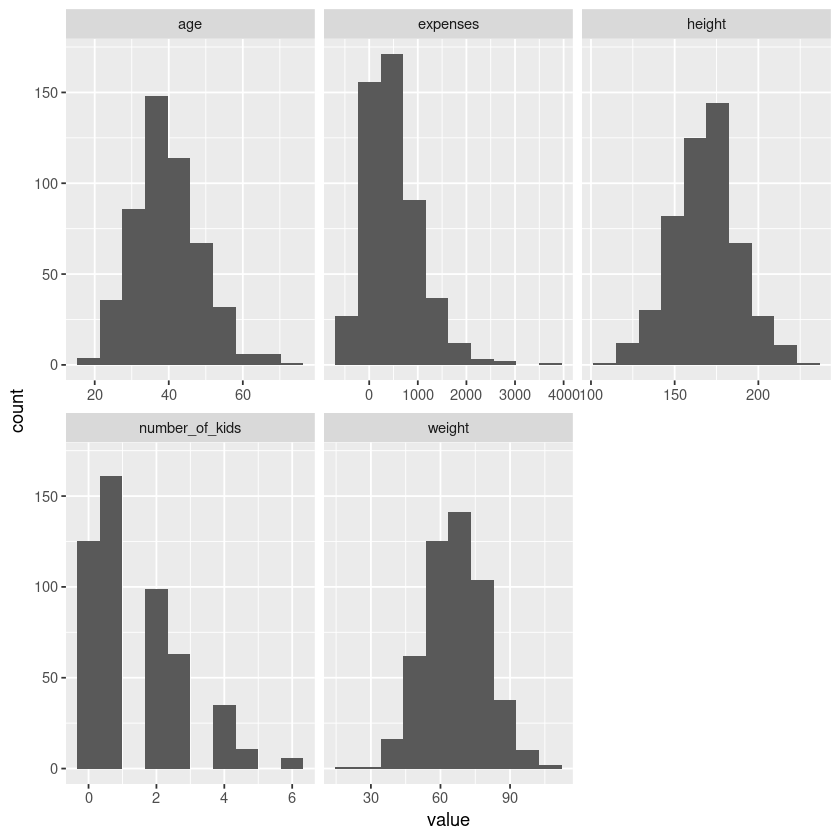

In [225]:
# Variables distributions, for having a complete insight into our data.

# https://stackoverflow.com/a/35373419
ggplot(gather(df[quantitive]), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x')

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


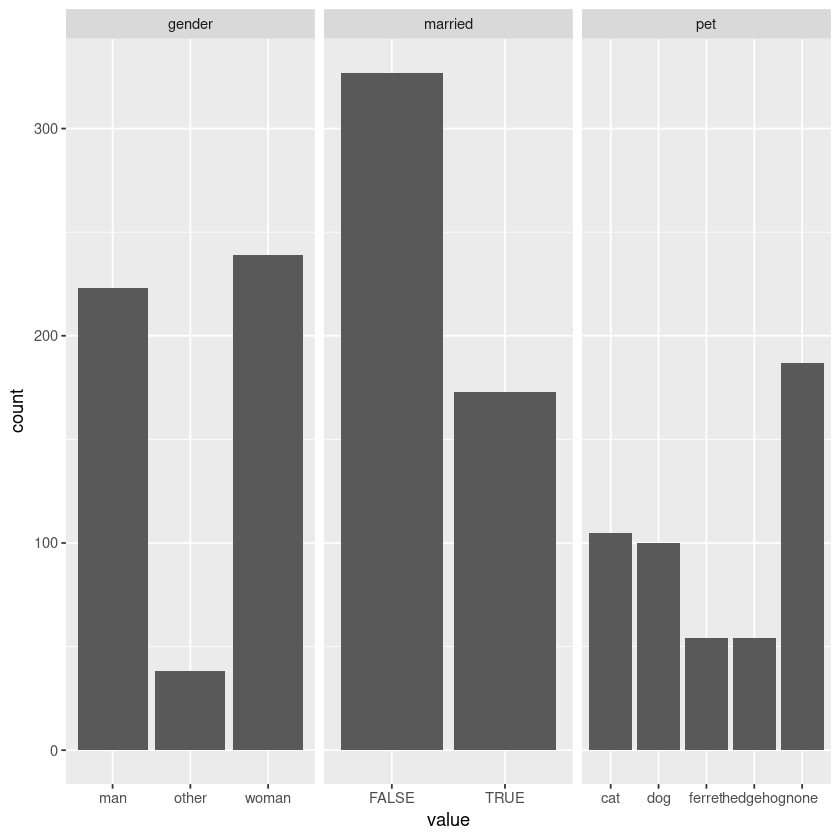

In [226]:
# barplots for categorical variables.
ggplot(gather(df[categorical]), aes(value)) + 
    geom_histogram(bins = 10, stat="count") + 
    facet_wrap(~key, scales = 'free_x')

At first glance distribution of _age_, _height_ and _weight_ seems to be disdtributed normally, while distribution of _number of kids_ and _expenses_ is similar to Gamma.

Let's look at boxplot and qqplot of _age_ variable.

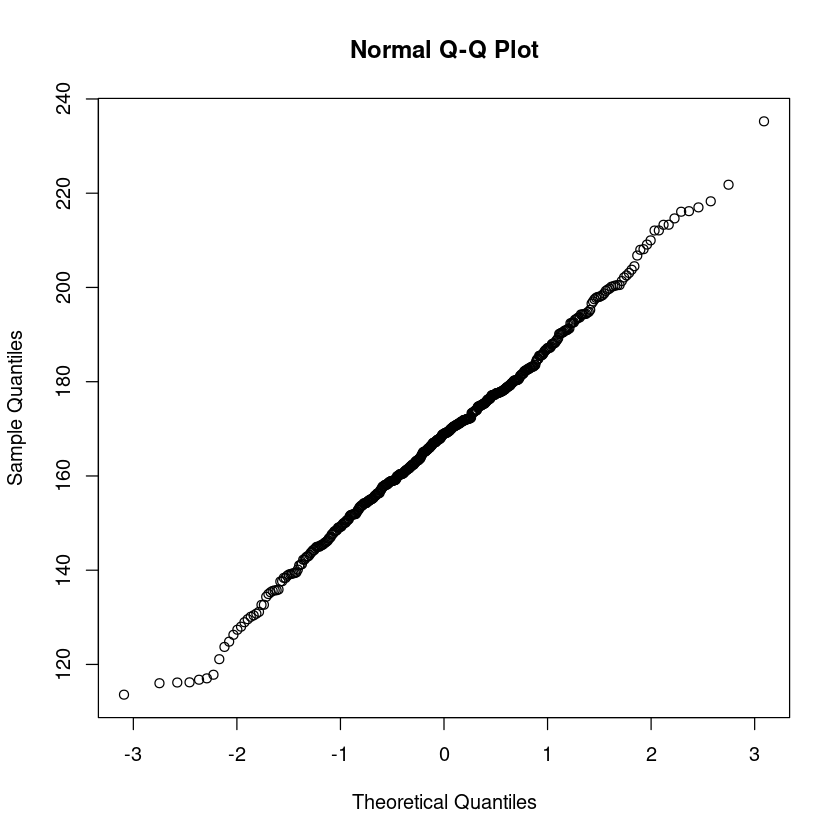

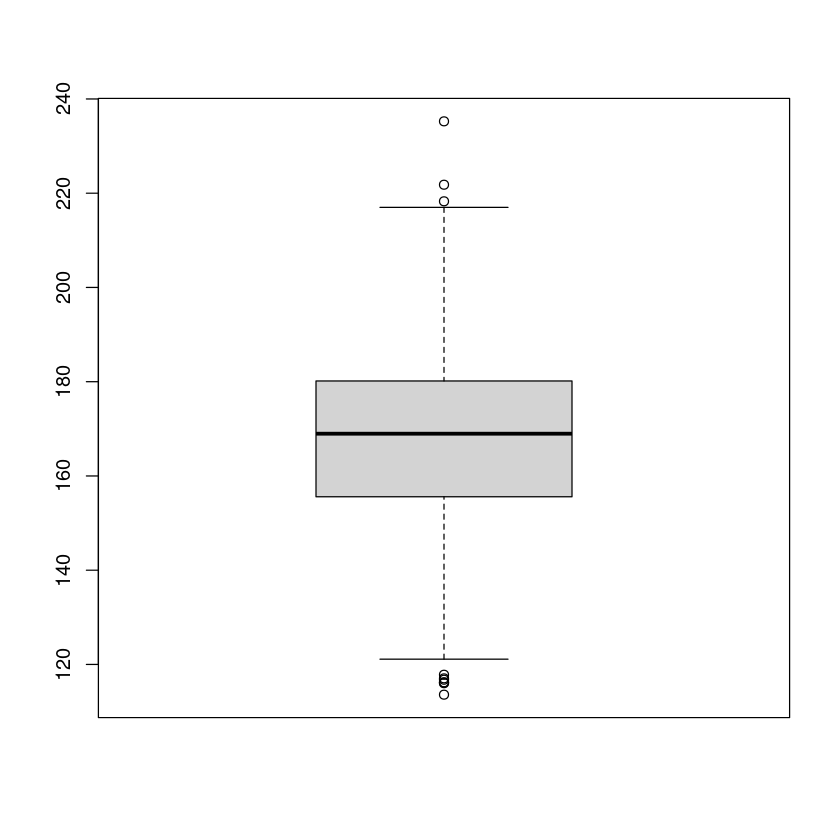

In [227]:
qqnorm(df$height)
boxplot(df$height)

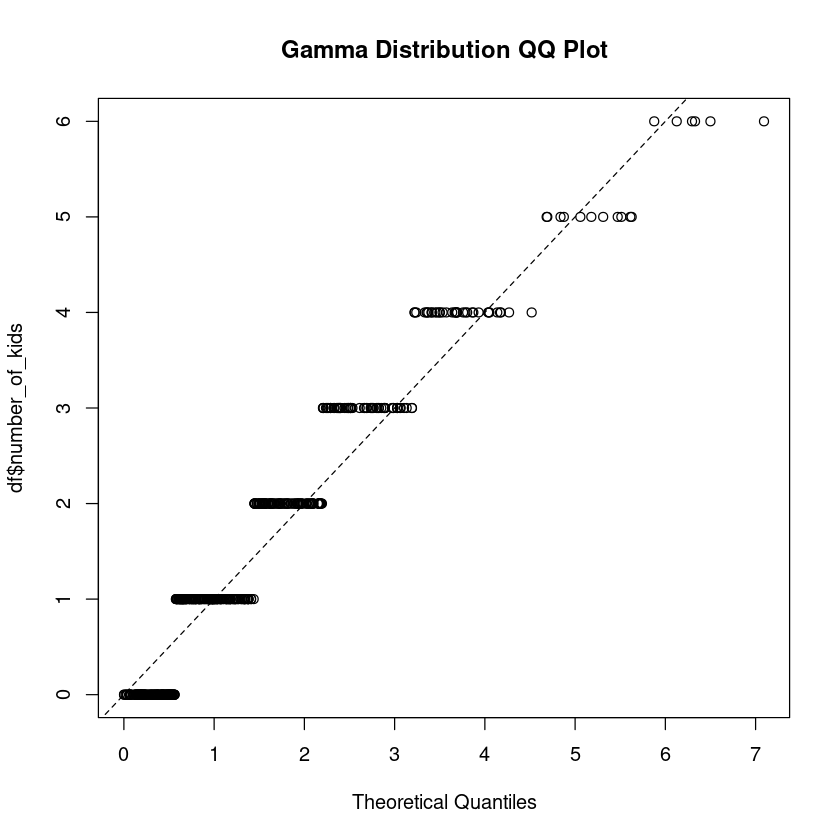

In [228]:
# install.packages("devtools")
# devtools::install_github("qPharmetra/qpToolkit")
library("qpToolkit")
qqGamma(df$number_of_kids)

In [260]:
# Calculate p-values for thesis about E(df$height) = 170, Med(df$height) = 165

#
### Assumptions:
#
# X ~ Norm(u, sig)
# u, sig - unknown

X = df$height
N = length(X)

# H1: u0 < 170
u0 = 170

est_val = (mean(X) - u0) * sqrt((N - 1) * N) / sqrt(sum((X - mean(X)) ** 2))

p = function(x) {print(glue(x, .envir=environment()))}

reject_h0 = function(est_val, alpha) {
    pvalue = stats::pt(est_val, df=N-1)
    threshold_value = -stats::qt(1-alpha, df=N-1)

    print(glue("est_val: {round(est_val, 3)}", .envir=environment()))
    print(glue("threshold range (W): (-Inf, {round(threshold_value, 3)}]", .envir=environment()))
    print(glue("pvalue: {round(pvalue, 3)}", .envir=environment()))
    est_val <= threshold_value
}

if (reject_h0(est_val, alpha=0.05)) {
    print("We *do* have basics to reject H0 (assuming alpha=0.05).")
} else { 
    print("We don't have basics to reject H0.")
}

est_val: -2.07
threshold range (W): (-Inf, -1.648]
pvalue: 0.019
[1] "We *do* have basics to reject H0 (assuming alpha=0.05)."


For mean value estimation I used t-Student test, under assumption that we sample from normal distribution. Was that assumption reasonable in terms of our data? 
I suppose that indeed _df$height_ samples come from normal distribution. Ealier we have seen _qqplot_ and _boxplot_, that showed significant similarity to normal disitribution.

For ground-truth results for both mean and medium value I use built-in R tests (t-Student and Wilcox).

In [242]:
t.test(X, alternative="less", mu=170)


	One Sample t-test

data:  X
t = -2.0699, df = 499, p-value = 0.01949
alternative hypothesis: true mean is less than 170
95 percent confidence interval:
    -Inf 169.629
sample estimates:
mean of x 
 168.1804 


In [16]:
wilcox.test(X, alternative="less", mu=165)


	Wilcoxon signed rank test with continuity correction

data:  X
V = 74416, p-value = 0.9999
alternative hypothesis: true location is less than 165


In [261]:
# Two-sided confidence intervals with alpha=0.01 for 'age' variable:
# a) Mean and standard deviation
# b) quantiles 1/4, 1/2, 3/4

X = df$age
N = length(X)
alpha = 1 - 0.99
S2 = 1/N * sum((X - mean(X))**2)

# Mean
mleft  = mean(X) - qt(1-alpha/2, df=N-1) * sqrt(S2) / sqrt(N - 1)
mright = mean(X) + qt(1-alpha/2, df=N-1) * sqrt(S2) / sqrt(N - 1)

p("Confidence interval for mean     (with alpha={alpha}) is ({round(mleft, 3)}, {round(mright, 3)})")

# Standard dev.
sdleft  = sqrt(N * S2 / qchisq(1-alpha/2, df=N-1))
sdright = sqrt(N * S2 / qchisq(alpha/2,   df=N-1))

p("Confidence interval for st. dev. (with alpha={alpha}) is ({round(sdleft, 3)}, {round(sdright, 3)})\n\n")

mean = mean(c(mleft, mright))
sd   = mean(c(sdleft, sdright))

# Quantiles
q = function(p) {round(qnorm(p, mean=mean, sd=sd), 3)}

for (quartile in c(1/4, 1/2, 3/4)) {
  p("{quartile} quantile: {q(quartile)}")
}

Confidence interval for mean     (with alpha=0.01) is (38.446, 40.522)
Confidence interval for st. dev. (with alpha=0.01) is (8.297, 9.768)

0.25 quantile: 33.392
0.5 quantile: 39.484
0.75 quantile: 45.576


The above results were obtained under assumption, that _age_ variable was sampled from normally distributed variable.

In [18]:
# Przetestuj na poziomie istotności 0.01 trzy hipotezy istotności:
# 1.różnicy między średnią wartością wybranej zmiennej dla kobiet i dla mężczyzn;
# 2.zależności między dwiema zmiennymi ilościowymi;
# 3.zależności między dwiema zmiennymi jakościowymi.


In [262]:
square = function(x) x**2
rss_gen = function(fm) {fm %>% residuals %>% square %>% sum}
tss_gen = function(fm) {(df$expenses - mean(df$expenses)) %>% square %>% sum}
r2_gen  = function(rss, tss) {1 - rss/tss}
p = function(x) {print(glue(x, .envir=environment()))}

print_lm_summary = function(rss, tss, r2) {
    p = function(x) {print(glue(x, .envir=environment()))}
    p("RSS: {rss}")
    p("TSS: {tss}")
    p("R2: {r2}")
}

lm_summary = function(fm) {
    rss = rss_gen(fm)
    tss = tss_gen(fm)
    r2 = r2_gen(rss, tss)

    print_lm_summary(rss, tss, r2)
}

# Performs linear regression of 'expenses' over all another columns.
# Returns fit object.
perform_regression = function(df, model_name) {
    print(paste("== Results of linear regression for model\"", model_name, "\":"))
    fm <- lm(expenses~., df)
    lm_summary(fm)
    print(summary(fm))
    fm
}

In [263]:
full_fit <- perform_regression(df, "All variables model")

[1] "== Results of linear regression for model\" All variables model \":"
RSS: 22328237.5348471
TSS: 160686928.927564
R2: 0.861045091322192

Call:
lm(formula = expenses ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-768.28 -127.24   -2.79  130.54  905.98 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -2276.7455   100.1447 -22.735  < 2e-16 ***
age               57.5889     1.0712  53.759  < 2e-16 ***
weight             1.2078     0.9984   1.210  0.22698    
height             2.0637     0.6580   3.136  0.00182 ** 
genderother       44.1656    37.7199   1.171  0.24222    
genderwoman      -21.7164    20.1406  -1.078  0.28146    
marriedTRUE       -9.8079    25.9461  -0.378  0.70559    
number_of_kids   -12.4393     8.8614  -1.404  0.16103    
petdog            29.2695    30.0801   0.973  0.33101    
petferret        406.6324    36.3026  11.201  < 2e-16 ***
pethedgehog      242.0460    35.9101   6.740 4.47e-11 ***
petnone   

'Full data' linear regression yields results with R^2=0.86. Let's take a look at summary and diagnosis plots to better understand data.

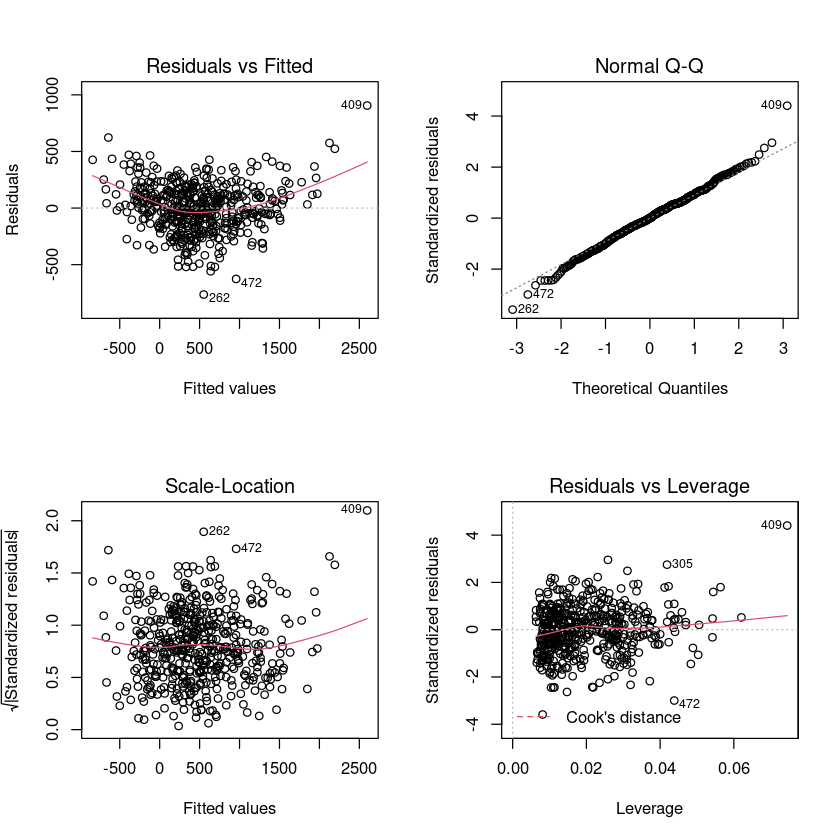

In [92]:
par(mfrow=c(2,2))
plot(full_fit)

'Residuals vs Fitted' plot suggests, that our data is non-linear, thus in next iterations we will add squared column. 

In [266]:
full_data = function() {
    DATA_FNAME = "people.tsv"
    df <- read.table(DATA_FNAME, header = TRUE,  sep = '\t',  stringsAsFactors = FALSE)
    df
}

hat = function(df) {
    stats::hat(df[,-which(names(df) == "expenses")])
}

gen_best_model = function() {
    DATA_FNAME = "people.tsv"
    df <- read.table(DATA_FNAME, header = TRUE,  sep = '\t',  stringsAsFactors = FALSE)
    
    # Handle pets (only 'ferret' and 'hedgehog' matter significantly)
    ferret_incides   = which(df$pet == "ferret")
    hedgehog_indices = which(df$pet == "hedgehog")
    df <- cbind(df, ferret=0, hedgehog=0)
    df$ferret[ferret_incides] = 1
    df$hedgehog[hedgehog_indices] = 1
    df <- df[, -which(names(df) == "pet")]
    
    # 'weight' is highly correlated with height so drop it; 'gender' and 'married' are not significant.
    df <- df[ , -which(names(df) %in% c("married", "weight", "gender"))]
    
    # diagnosis plots showed non-linear dependency in data, try using squared 'age'.
    df <- cbind(df, df$age**2) 

    df
}

best_fit <- perform_regression(gen_best_model(), "Trimmed, best-yield model.")

[1] "== Results of linear regression for model\" Trimmed, best-yield model. \":"
RSS: 18557405.0781514
TSS: 160686928.927564
R2: 0.884512043375246

Call:
lm(formula = expenses ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-682.62 -123.93   -2.94  140.61  489.60 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -978.13190  151.82829  -6.442 2.80e-10 ***
age              -5.27363    6.11688  -0.862    0.389    
height            2.31543    0.44467   5.207 2.82e-07 ***
number_of_kids  -11.61687    6.28123  -1.849    0.065 .  
ferret          391.95396   28.32523  13.838  < 2e-16 ***
hedgehog        220.68328   28.19417   7.827 3.07e-14 ***
`df$age^2`        0.74874    0.07207  10.389  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 194 on 493 degrees of freedom
Multiple R-squared:  0.8845,	Adjusted R-squared:  0.8831 
F-statistic: 629.3 on 6 and 493 DF,  p-value: < 2.2e-1

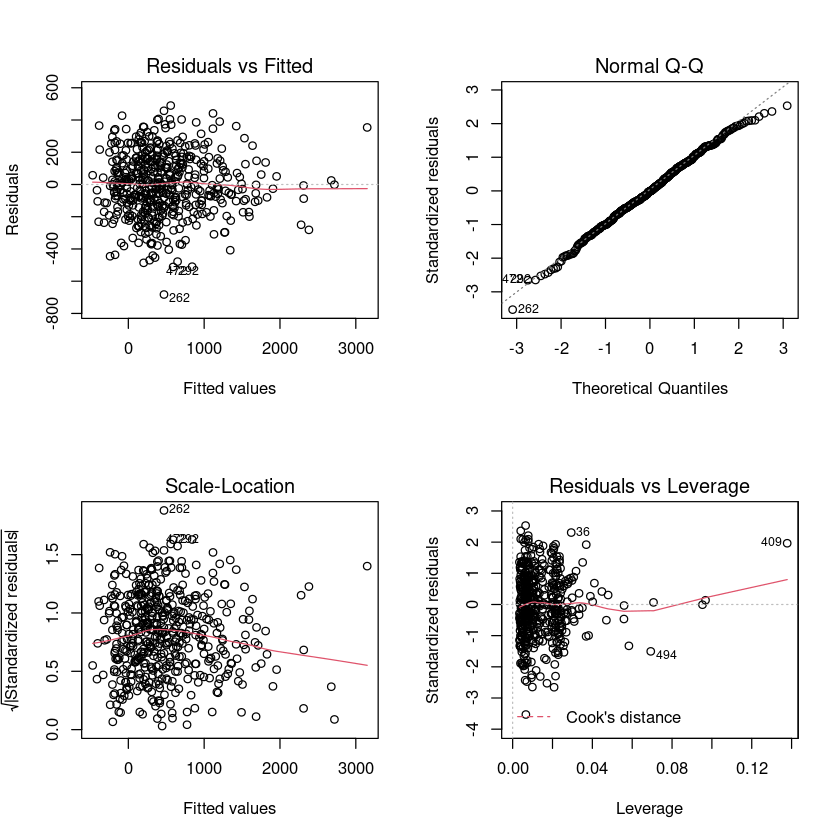

In [267]:
par(mfrow=c(2,2))
plot(best_fit)

Adding `age^2` column resulted in more linear, close to zero residuals and 0.88 R^2 value.

For even better results let's try removing outlier observations.

In [268]:
best_fit_full_row <- perform_regression(gen_best_model(), "Best model without outliers")

M = model.matrix(best_fit_full_row)
N = dim(M)[1]
P = dim(M)[2]

sig = sigma(best_fit_full_row)
leverage = hatvalues(best_fit_full_row)

se = residuals(fm) / (sig * sqrt(1 - leverage))
which(se > 3)
# remove some outliers rows.
df_no_outliers <- gen_best_model()
df_no_outliers <- df_no_outliers[-which(se > 3),]
best_fit_no_outliers <- perform_regression(df_no_outliers, "Best model without outliers")

[1] "== Results of linear regression for model\" Best model without outliers \":"
RSS: 18557405.0781514
TSS: 160686928.927564
R2: 0.884512043375246

Call:
lm(formula = expenses ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-682.62 -123.93   -2.94  140.61  489.60 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -978.13190  151.82829  -6.442 2.80e-10 ***
age              -5.27363    6.11688  -0.862    0.389    
height            2.31543    0.44467   5.207 2.82e-07 ***
number_of_kids  -11.61687    6.28123  -1.849    0.065 .  
ferret          391.95396   28.32523  13.838  < 2e-16 ***
hedgehog        220.68328   28.19417   7.827 3.07e-14 ***
`df$age^2`        0.74874    0.07207  10.389  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 194 on 493 degrees of freedom
Multiple R-squared:  0.8845,	Adjusted R-squared:  0.8831 
F-statistic: 629.3 on 6 and 493 DF,  p-value: < 2.2e-

188 409 
188 409

[1] "== Results of linear regression for model\" Best model without outliers \":"
RSS: 18267309.9812827
TSS: 160686928.927564
R2: 0.886317386839116

Call:
lm(formula = expenses ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-688.96 -124.90   -2.06  135.56  488.01 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.072e+03  1.550e+02  -6.921 1.41e-11 ***
age            -9.881e-02  6.390e+00  -0.015   0.9877    
height          2.292e+00  4.422e-01   5.184 3.18e-07 ***
number_of_kids -1.304e+01  6.288e+00  -2.074   0.0386 *  
ferret          3.921e+02  2.816e+01  13.923  < 2e-16 ***
hedgehog        2.139e+02  2.830e+01   7.558 2.02e-13 ***
`df$age^2`      6.848e-01  7.586e-02   9.028  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 192.9 on 491 degrees of freedom
Multiple R-squared:  0.8792,	Adjusted R-squared:  0.8778 
F-statistic: 595.8 on 6 and 491 DF,  p-value: < 2.2

Unfortunately, removing 2 outliers (188, 409) decreased our R^2 metric. 

Let's try also removing observations with both high leverage and high residual.

[1] "== Results of linear regression for model\" Best model without outliers \":"
RSS: 18137820.8788501
TSS: 160686928.927564
R2: 0.887123233981114

Call:
lm(formula = expenses ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-681.57 -124.06   -0.34  138.28  487.11 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -984.31318  155.51916  -6.329 5.57e-10 ***
age              -3.99309    6.45331  -0.619    0.536    
height            2.22067    0.44245   5.019 7.28e-07 ***
number_of_kids  -10.15204    6.26045  -1.622    0.106    
ferret          390.86168   28.09094  13.914  < 2e-16 ***
hedgehog        204.09482   28.47386   7.168 2.82e-12 ***
`df$age^2`        0.73044    0.07712   9.471  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 192.4 on 490 degrees of freedom
Multiple R-squared:  0.8772,	Adjusted R-squared:  0.8757 
F-statistic: 583.3 on 6 and 490 DF,  p-value: < 2.2

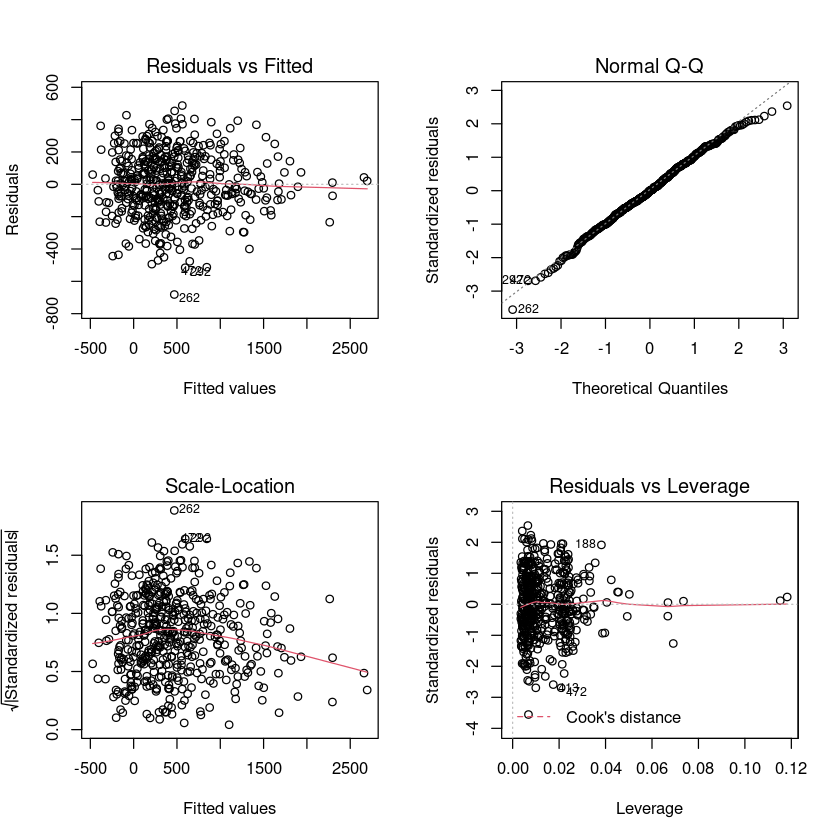

In [270]:
df_leverage <- gen_best_model()
df_leverage <- df_leverage[-c(409, 494, 36),]
best_fit_leverage <- perform_regression(df_leverage, "Best model without outliers")
par(mfrow=c(2,2))
plot(best_fit_leverage)

Removing high-error-and-leverage observations also hadn't improved accuracy. 

Do classical regression assumptions hold for our model?
I suppose yes. Please look at plot below - we cannot observe variance escalation with groving expenses.

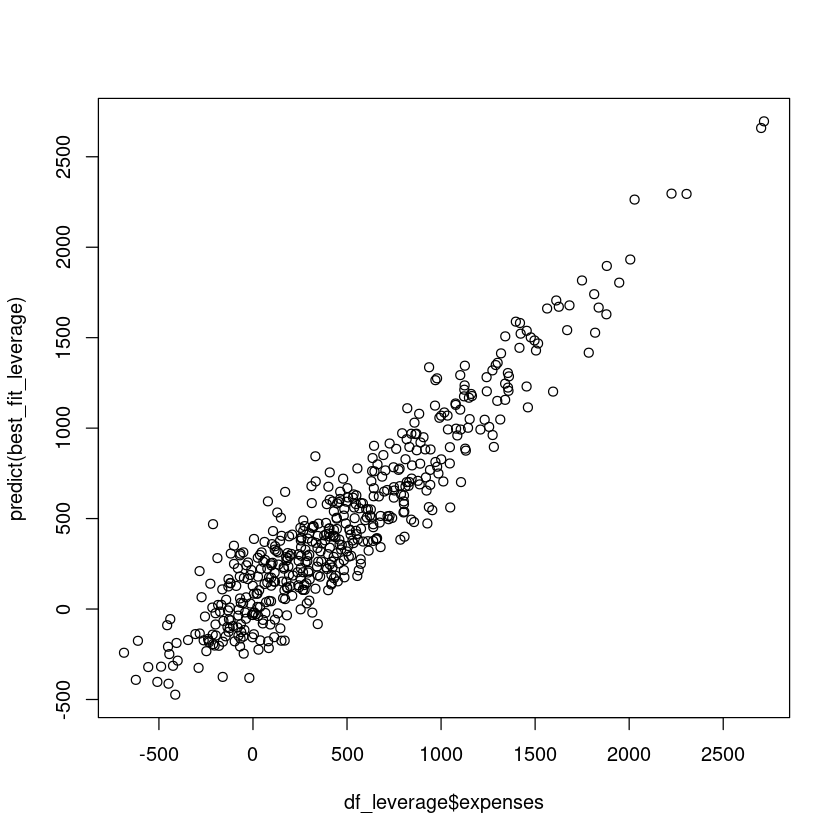

In [273]:
plot(x=df_leverage$expenses, y=predict(best_fit_leverage))